<H1>Red Hat NLP Spark Project</H1>

This notebook uses Red Hat's OpenShift data logs and processes them using Drain3. 

The first thing this notebook does is webscrape the OpenShift logs and installs dependencies. After, the logs are then cleaned by removing leading tags, dates, timestamps and other unique identifiers. This is done manually because Drain3 does not do this consistently for all logs. Finally the parsed logs are then fed into Drain3 and then put into a dictionary sorted by cluster ID.

The final step that needs to be done is to sift out the pass and fail logs based on their cluster ID and visualize our data.

In [ ]:
!pip3 install drain3
!pip3 install kafka-python
!pip3 install redis
!pip install -q tf-models-official

  Created wheel for drain3: filename=drain3-0.9.5-cp37-none-any.whl size=18179 sha256=df021c63200c550dc0982b1034ed467c35c5686e7d82a2590d27a205bb6ec15f
  Stored in directory: /root/.cache/pip/wheels/11/a1/08/125223534f199f0db7a435b437015f83abba341ef0f4f6c64f
Successfully built drain3
     |████████████████████████████████| 256kB 5.8MB/s 
     |████████████████████████████████| 81kB 3.2MB/s 
     |████████████████████████████████| 1.1MB 5.7MB/s 
     |████████████████████████████████| 174kB 13.4MB/s 
     |████████████████████████████████| 1.2MB 18.3MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 358kB 28.6MB/s 
     |████████████████████████████████| 706kB 28.8MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
     |████████████████████████████████| 645kB 39.7MB/s 
     |████████████████████████████████| 37.6MB 1.3MB/s 


In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from google.colab import files
import pandas as pd
import io
import numpy as np
import dateutil
from dateutil import parser
import textblob
import requests
import matplotlib.pyplot as plt
import json
import pickle
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import drain3
from drain3 import TemplateMiner
import json
import logging
import sys
from drain3.kafka_persistence import KafkaPersistence
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import subprocess
import time
import spacy

from xgboost import XGBClassifier
import os, os.path


#<H3>Dataset</H3>

Gather log files from OpenShift and save them to shared google drive, Red Hat & BU.

In [ ]:

#enable to read files from the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open ('/content/drive/MyDrive/RedHat_BU/log/log_file_1.ob', 'rb') as fp:
    logs1 = pickle.load(fp)
#print(logs[1])

with open ('/content/drive/MyDrive/RedHat_BU/label/label_file_1.ob', 'rb') as fp:
    labels1 = pickle.load(fp)
#print(labels)

print("number of logs: ", len(logs1))
print("number of labels: ",len(labels1))

number of logs:  416
number of labels:  416


In [ ]:
#increase data size by twice (416+452=868)
with open ('/content/drive/MyDrive/RedHat_BU/log/log_file_2.ob', 'rb') as fp:
    logs2 = pickle.load(fp)
#print(logs[1])

with open ('/content/drive/MyDrive/RedHat_BU/label/label_file_2.ob', 'rb') as fp:
    labels2 = pickle.load(fp)
#print(labels)
print("number of logs: ", len(logs2))
print("number of labels: ",len(labels2))

number of logs:  452
number of labels:  452


In [ ]:
#increase data size by 3 times (868+2958=3826)
with open ('/content/drive/MyDrive/RedHat_BU/log/log_file_3.ob', 'rb') as fp:
    logs3 = pickle.load(fp)
#print(logs[1])

with open ('/content/drive/MyDrive/RedHat_BU/label/label_file_3.ob', 'rb') as fp:
    labels3 = pickle.load(fp)
#print(labels)
print("number of logs: ", len(logs3))
print("number of labels: ",len(labels3))

number of logs:  2958
number of labels:  2958


In [ ]:
#increase data size     3826+168=3994
with open ('/content/drive/MyDrive/RedHat_BU/log/log_file_4.ob', 'rb') as fp:
    logs4 = pickle.load(fp)
#print(logs[1])

with open ('/content/drive/MyDrive/RedHat_BU/label/label_file_4.ob', 'rb') as fp:
    labels4 = pickle.load(fp)
#print(labels)
print("number of logs: ", len(logs4))
print("number of labels: ",len(labels4))

number of logs:  168
number of labels:  168


In [ ]:
logs = logs1# + logs2 + logs3 + logs4 
labels = labels1# + labels2 + labels3 + labels4 
print("number of logs: ", len(logs))
print("number of labels: ",len(labels))

number of logs:  416
number of labels:  416


#<H4>Assigning Labels to Logs </H4>

In [ ]:
# 1 := success, 0 := fail
y = []
count_0 = 0
count_1 = 0
for label in labels:
  if label == 'SUCCESS':
    y.append(1)
    count_1 = count_1 + 1
  else:
    y.append(0)
    count_0 = count_0 + 1
print("y = ", y)
print("number of success/1 = ", count_1)
print("number of fail/0 = ", count_0)

y =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1

<H4>Splitting log lines for vectorization</H4>

In [ ]:
vocab = {}
i = 0
for log in logs:
  log = str(log).split(",")
  for line in log:
    line = line.replace("'","").replace(" ","").replace("\"","")
    if line not in vocab:
      vocab[line] = i
      i+=1
print(len(vocab))

39584


In [ ]:
#print(list(vocab.items())[:100])

#<H2>Classifying logs without Drain3 and parsing</H2>

Here begins the process of vectorizing each log line and then classifying it as a pass or fail log accordingly. If this cell has an error, run the cell that removes newline characters and the leading b' tag from the logs.

In [ ]:
vectorizer = TfidfVectorizer(vocabulary = vocab)

X = vectorizer.fit_transform(logs)

In [ ]:
X.shape

(416, 39584)

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size= 0.8, random_state=1)
sss.get_n_splits(X, y)
y = np.array(y)
for train_index, test_index in sss.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

In [ ]:
#tfidf
X_train.shape

(332, 39584)

# Classifying logs without Drain3 with XGB




In [ ]:
#training accuracy calculator
def accuracy_cal(prediction, Testy):
    count = 0
    for i in range(len(prediction)):
        if prediction[i] == int(Testy[i]):
            count+=1
    accuracy = round(count / len(prediction) * 100, 4)
    #print(accuracy, "%")
    return accuracy



In [ ]:
model_XGB = XGBClassifier(scale_pos_weight=99).fit(X_train, y_train)
y_test_predictions = model_XGB.predict(X_test)
accuracy = accuracy_cal(y_test_predictions, y_test)

y_train_predictions = model_XGB.predict(X_train)
training_error = mean_squared_error(y_train,y_train_predictions)


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_test_predictions))

print("=== Classification Report ===")
print(classification_report(y_test, y_test_predictions))

print("Training error: ",round(training_error,4))
print("Training accuracy: ", accuracy,"%")
print("Precision score: {}".format(precision_score(y_test, y_test_predictions)))
print("Recall score: {}".format(recall_score(y_test, y_test_predictions)))
print("F1 Score: {}".format(f1_score(y_test, y_test_predictions)))

=== Confusion Matrix ===
[[24  4]
 [ 0 56]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        28
           1       0.93      1.00      0.97        56

    accuracy                           0.95        84
   macro avg       0.97      0.93      0.94        84
weighted avg       0.96      0.95      0.95        84

Training error:  0.0422
Training accuracy:  95.2381 %
Precision score: 0.9333333333333333
Recall score: 1.0
F1 Score: 0.9655172413793104


#<H3>Parsing logs before processing into Drain3</H3>

Logs need to be parsed before processing into Drain3. This is necessary because Drain3 does not parse consistently for every log.

Things to be parsed:
<ul>
  <li>Dates</li>
  <li>Timestamps</li>
  <li>Newline characters</li>
  <li>Version numbers</li>
  <li>Namespace IDs</li>
  <li>URLs</li>
</ul>

In [ ]:
original_log = logs[1]
#print(original_log)

In [ ]:
#  helper function detecting if a string is a date / timestamp
parsed_logs = []
def is_date(str):
  try:
    dateutil.parser.parse(str)
    return True
  except:
    return False
for i in range(len(logs)):
 # splitting each section as its own index (for parsing)
  parsed_logs.append(str(logs[i]).split(' '))
  for j in range(len(parsed_logs[i])):
    if is_date(parsed_logs[i][j]) == True:
      parsed_logs[i][j] = ''
  parsed_logs[i] = list(filter(lambda x: x != '', parsed_logs[i]))
  parsed_logs[i] = ' '.join(parsed_logs[i])

This code cell removes timestamps and dates in order to mitigate unique identifiers

In [ ]:
for index in range(len(parsed_logs)):
  # removing version number
  if "version" in parsed_logs[index]:
    tmp = parsed_logs[index].split("version",1)
    tmp_1 = tmp[0]
    tmp_2 = tmp[1].split()
    tmp_2 = tmp_2[1:]
    tmp = ''.join(tmp_1) + ' '.join(tmp_2)
    parsed_logs[index] = tmp

  # removing creating namespace ID
  if "Creating namespace" in parsed_logs[index]:
    tmp = parsed_logs[index].split("Creating namespace", 1)
    tmp_1 = tmp[0]
    tmp_2 = tmp[1].split()
    tmp_2 = tmp_2[1:]
    tmp = ''.join(tmp_1) + ' '.join(tmp_2)
    parsed_logs[index] = tmp

  # removing using namespace ID
  if "Using namespace" in parsed_logs[index]:
    tmp = parsed_logs[index].split("Using namespace", 1)
    tmp_1 = tmp[0]
    tmp_2 = tmp[1].split()
    tmp_2 = tmp_2[1:]
    tmp = ''.join(tmp_1) + ' '.join(tmp_2)
    parsed_logs[index] = tmp

  # removing Imported release stamp
  if "Imported release" in parsed_logs[index]:
    tmp = parsed_logs[index].split("Imported release", 1)
    tmp_1 = tmp[0]
    tmp_2 = tmp[1].split()
    tmp_2 = tmp_2[1:]
    tmp = ''.join(tmp_1) + ' '.join(tmp_2)
    parsed_logs[index] = tmp

  # removing Acquired lease stamp
  if "Acquired lease" in parsed_logs[index]:
    tmp = parsed_logs[index].split("Acquired lease", 1)
    tmp_1 = tmp[0]
    tmp_2 = tmp[1].split()
    tmp_2 = tmp_2[1:]
    tmp = ''.join(tmp_1) + ' '.join(tmp_2)
    parsed_logs[index] = tmp

  # removing "images will be pullable from" link
  if "images will be pullable from" in parsed_logs[index]:
    tmp = parsed_logs[index].split("images will be pullable from", 1)
    tmp_1 = tmp[0]
    tmp_2 = tmp[1].split()
    tmp_2 = tmp_2[1:]
    tmp = ''.join(tmp_1) + ' '.join(tmp_2)
    parsed_logs[index] = tmp

#<H3>Drain3 Processing</H3>

The parsed logs are now being processed in Drain3. Drain3 will do additional parsing and also cluster the logs. Drain3 uses longest common subsequence as their algorithm for clustering, so logs with similar structure will be considered to be in the same clustering. There are two dictionaries that represent the size of each cluster and another that separates the logs by cluster ID. The goal of this is to determine which clusters are pass logs and which clusters are fail logs.

In [ ]:

template_miner = TemplateMiner(None)
i = 0
ints_from_drain = []
while True:
    if i >= len(parsed_logs):
      break
    log_line = ' '.join(parsed_logs[i])
    i += 1
    if log_line == 'q':
        break
    result = template_miner.add_log_message(log_line)
    result_json = json.dumps(result)
    ints_from_drain.append(re.findall(r'\d+', result_json))
    # print(result_json)

ints_from_drain = np.asarray(ints_from_drain)

cluster_size = {}
cluster_id = {}
for cluster in template_miner.drain.clusters:
  if cluster.cluster_id not in cluster_size:
    cluster_size[cluster.cluster_id] = cluster.size
    cluster_id[cluster.cluster_id] = []


for i in range(len(ints_from_drain)):
  cluster_id[int(ints_from_drain[i][0])].append(parsed_logs[i])

print(cluster_size)


{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 10, 91: 2, 92: 16, 93: 10, 94: 2, 95: 10, 96: 2, 97: 4, 98: 2, 99: 2, 100: 12, 101: 2, 102: 2, 103: 2, 104: 6, 105: 2, 106: 2, 107: 2, 108: 2, 109: 34, 110: 2, 111: 2, 112: 2, 113: 2, 114: 6, 115: 2, 116: 2, 117: 2, 118: 20, 119: 2, 120: 2, 121: 2, 122: 2, 123: 2, 124: 6, 125: 2, 126: 6, 127: 4, 128: 74, 129: 8, 130: 2, 131: 2, 132: 2, 133: 2, 134: 6, 135: 4, 136: 2, 137: 2, 138

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#<H3>Parsing Results Print out</H3>

Here is a snippet example of what the parsing process does to each log. As you can see the leading byte tag, dates, and unique URLs will be parsed out from both manual parsing and Drain3.

In [ ]:
print(original_log.split(',')[:3])
print(parsed_logs[1].split(',')[:3])

['b\'2020/10/28 22:31:45 ci-operator version v20201028-4f6c4ca"', " '2020/10/28 22:31:45 No source defined'", " '2020/10/28 22:31:45 Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.5-ci'"]
["b'2020/10/28 ci-operator No source defined'", " Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.5-ci'", ' Running [release-inputs]']


#<H4>Log cluster example</H4>

Here is a printout of logs that fall under a cluster with the ID of 94. This cluster contains the most amount of data logs. Based on the clustering algorithm it is evident that Drain3 uses longest common sequence because all of these logs in this cluster contain the exact same structure with very small differences, especially after being parsed.

In [ ]:
i = 1
for log in cluster_id[95]:
  print("log", i, ":",  log[:200], "...")
  print()
  i += 1

log 1 : b'2020/11/10 ci-operator No source defined', Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.1', warning: overriding parameter "LEASED_RESOURCE"', Running [release-inputs], e2e- ...

log 2 : b'2020/11/11 ci-operator No source defined', Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.1', warning: overriding parameter "LEASED_RESOURCE"', Running [release-inputs], e2e- ...

log 3 : b'2020/11/12 ci-operator No source defined', Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.1', warning: overriding parameter "LEASED_RESOURCE"', Running [release-inputs], e2e- ...

log 4 : b'2020/11/13 ci-operator No source defined', Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.1', warning: overriding parameter "LEASED_RESOURCE"', Running [release-inputs], e2e- ...

log 5 : b'2020/11/15 ci-operator No source defined', Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.1', warning: overrid

#<H2>Classifying logs with Drain3 and parsing</H2>

In [ ]:
vocab = {}
i = 0
hhh = []
for log in parsed_logs:
  log = str(log).split(",")
  for line in log:
    line = line.replace("'","").replace(" ","").replace("\"","")
    if line not in vocab:
      vocab[line] = i
      i+=1
print(len(vocab))
# print(hhh)

27820


<H4>Vectorizing log lines</H4>

In [ ]:
vectorizer = TfidfVectorizer(vocabulary = vocab)
X2 = vectorizer.fit_transform(parsed_logs)


In [ ]:
print(X2.shape)

(416, 27820)


In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size= 0.8, random_state=1)
sss.get_n_splits(X2, y)
y = np.array(y)
for train_index, test_index in sss.split(X2, y):
  X_train2, X_test2 = X2[train_index], X2[test_index]
  y_train, y_test = y[train_index], y[test_index]

In [ ]:
#tfidf
X_train2.shape

(332, 27820)

# Classifying logs with Drain3 with XGB

In [ ]:
model_XGB_D = XGBClassifier(scale_pos_weight=99).fit(X_train2, y_train)
y_test_predictions = model_XGB_D.predict(X_test2)
accuracy = accuracy_cal(y_test_predictions, y_test)

y_train_predictions = model_XGB_D.predict(X_train2)
training_error = mean_squared_error(y_train,y_train_predictions)


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_test_predictions))

print("=== Classification Report ===")
print(classification_report(y_test, y_test_predictions))


print("Training error: ",round(training_error,4))
print("Training accuracy: ", accuracy,"%")
print("Precision score: {}".format(precision_score(y_test, y_test_predictions)))
print("Recall score: {}".format(recall_score(y_test, y_test_predictions)))
print("F1 Score: {}".format(f1_score(y_test, y_test_predictions)))

=== Confusion Matrix ===
[[21  7]
 [ 0 56]]
=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        28
           1       0.89      1.00      0.94        56

    accuracy                           0.92        84
   macro avg       0.94      0.88      0.90        84
weighted avg       0.93      0.92      0.91        84

Training error:  0.0753
Training accuracy:  91.6667 %
Precision score: 0.8888888888888888
Recall score: 1.0
F1 Score: 0.9411764705882353


#Visualizations


In [ ]:
k = [100,200,300,400,416]
#k = [200,400,600,800,868]
#k = [700,1400,2100,2800,3500,3826]
#k = [500,1000,1500,2000,2500,3000,3500,3994]
sdp=[]
snp=[]
sdf1=[]
snf1=[]
acc_n = []
acc_d = []
X[0:k[0]].shape
for i in range(len(k)):
  DrainX = X[0:k[i]]
  NoDrainX = X2[0:k[i]]
  lb = y[0:k[i]]
  sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size= 0.8, random_state=1)
  sss.get_n_splits(DrainX, lb)
  lb = np.array(lb)
  for train_index, test_index in sss.split(DrainX, lb):
    Xd_train, Xd_test = DrainX[train_index], DrainX[test_index]      
    Xn_train, Xn_test = NoDrainX[train_index], NoDrainX[test_index]  
    y_train, y_test = lb[train_index], lb[test_index]

  model_XGB_D = XGBClassifier(scale_pos_weight=99).fit(Xd_train, y_train) 
  yd_test_predictions = model_XGB_D.predict(Xd_test)
  sd_pre = precision_score(y_test, yd_test_predictions)
  sdp.append(sd_pre)
  sd_f1 = f1_score(y_test, yd_test_predictions)
  sdf1.append(sd_f1)
  acc_d.append(accuracy_cal(yd_test_predictions, y_test))

  model_XGB = XGBClassifier(scale_pos_weight=99).fit(Xn_train, y_train) 
  yn_test_predictions = model_XGB.predict(Xn_test)
  sn_pre = precision_score(y_test, yn_test_predictions)
  snp.append(sn_pre)
  sn_f1 = f1_score(y_test, yn_test_predictions)
  snf1.append(sn_f1)
  acc_n.append(accuracy_cal(yn_test_predictions, y_test))

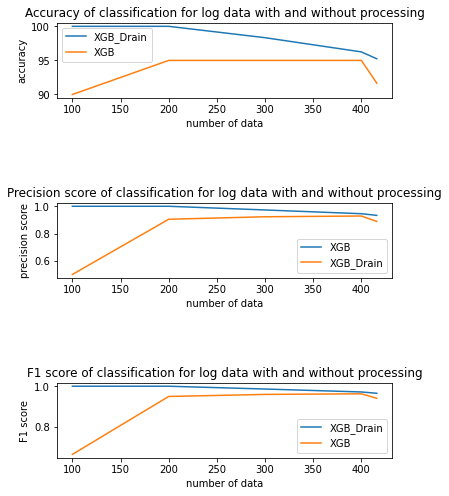

In [ ]:
fig = plt.figure(figsize=(6,8))

fig.subplots_adjust(hspace=1.4, wspace=1.4)
ax = fig.add_subplot(3, 1, 1)
ax.plot(k, acc_d, label = "XGB_Drain")
ax.plot(k, acc_n, label = "XGB")
plt.xlabel("number of data")
plt.ylabel("accuracy")
plt.title('Accuracy of classification for log data with and without processing')
plt.legend()

ax = fig.add_subplot(3, 1, 2)
ax.plot(k, sdp, label = "XGB")
ax.plot(k, snp, label = "XGB_Drain")
plt.xlabel("number of data")
plt.ylabel("precision score")
plt.title('Precision score of classification for log data with and without processing')
plt.legend()

ax = fig.add_subplot(3, 1, 3)
ax.plot(k, sdf1, label = "XGB_Drain")
ax.plot(k, snf1, label = "XGB")
plt.xlabel("number of data")
plt.ylabel("F1 score")
plt.title('F1 score of classification for log data with and without processing')
plt.legend()
plt.show()

#<h3>Cross validation</h3>
the code below it to verify if there is overfit in our model when the dataset size changes


In [ ]:
k = [100,200,300,400,416]
#k = [200,400,600,800,868]
#k = [700,1400,2100,2800,3500,3826]
#k = [500,1000,1500,2000,2500,3000,3500,3994]
scores_d = [] #Drain
scores_s = [] #No Drain
for i in range(len(k)):
  DrainX = X[0:k[i]]
  NoDrainX = X2[0:k[i]]
  lb = y[0:k[i]]
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # evaluate model
  scores_d.append(np.mean(cross_val_score(model_XGB_D, DrainX, lb, scoring='roc_auc', cv=cv, n_jobs=-1)))
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # evaluate model
  scores_s.append(np.mean(cross_val_score(model_XGB, NoDrainX, lb, scoring='roc_auc', cv=cv, n_jobs=-1)))


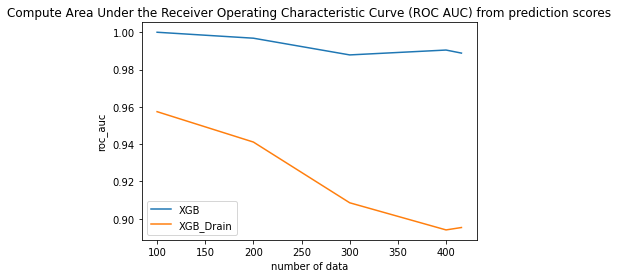

In [ ]:
#fig = plt.figure(figsize=(6,8))


plt.plot(k, scores_d, label = "XGB")
plt.plot(k, scores_s, label = "XGB_Drain")
plt.xlabel("number of data")
plt.ylabel("roc_auc")
plt.title('Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores')
plt.legend()
